In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 54kB/s 


In [2]:
!nvidia-smi

Thu Dec  3 18:04:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [4]:
# import the libraries as shown below

import shutil
import os
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]



In [6]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [7]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/cell_images/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)    

train_generator = datagen_train.flow_from_directory(
    '/content/drive/MyDrive/cell_images',
    seed=42,
    target_size=(224,224),
    batch_size=16, 
    shuffle=True,
    subset='training',
    class_mode = 'categorical')

val_generator = datagen_val.flow_from_directory(
    '/content/drive/MyDrive/cell_images',
    seed=42,
    target_size=(224,224),
    batch_size=16, 
    shuffle=True,
    subset='validation',
    class_mode = 'categorical')


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [17]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_generator,
  validation_data=val_generator,
  epochs=20,
  steps_per_epoch=len(train_generator),
  validation_steps=len(val_generator)
)

Epoch 1/20
1378/1378 [==============================] - 11938s 9s/step - loss: 0.3828 - accuracy: 0.8401 - val_loss: 0.3306 - val_accuracy: 0.8662
Epoch 2/20
1378/1378 [==============================] - 309s 224ms/step - loss: 0.3458 - accuracy: 0.8781 - val_loss: 0.3208 - val_accuracy: 0.8844
Epoch 3/20
1378/1378 [==============================] - 305s 222ms/step - loss: 0.3225 - accuracy: 0.8921 - val_loss: 0.2974 - val_accuracy: 0.8898
Epoch 4/20
1378/1378 [==============================] - 306s 222ms/step - loss: 0.3130 - accuracy: 0.9009 - val_loss: 0.5818 - val_accuracy: 0.8408
Epoch 5/20
1378/1378 [==============================] - 312s 226ms/step - loss: 0.3021 - accuracy: 0.9047 - val_loss: 0.5215 - val_accuracy: 0.8472
Epoch 6/20
1378/1378 [==============================] - 309s 225ms/step - loss: 0.3003 - accuracy: 0.9069 - val_loss: 0.4037 - val_accuracy: 0.8766
Epoch 7/20
1378/1378 [==============================] - 305s 221ms/step - loss: 0.2932 - accuracy: 0.9103 - val_l

In [18]:
import matplotlib.pyplot as plt

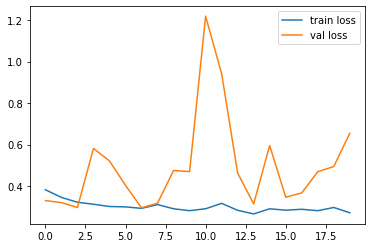

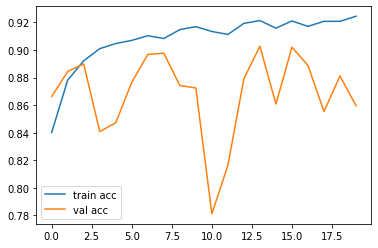

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/malaria_detection.h5')